In [3]:
import numpy as np
import torch
import pandas as pd
from tqdm.auto import tqdm
import pickle
import copy
import sys
from os import path
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer, Rotator
from joblib import Parallel, delayed
from matplotlib.colors import LinearSegmentedColormap

import sys
sys.path.append('../sloth/')
from sloth import *
from definitions import *

device = 'cpu'
d=3 #Sloth dimensions

colors = ["blue", "white", "red"]#, "black"
colormap = "coolwarm" #LinearSegmentedColormap.from_list("GreenRed", colors)

Loading and prepating data

In [4]:
data = pd.read_csv('../data/data_v2.csv')
data['logS'] = np.log10(data['#Params (B)'])
data['logT'] = np.log10(data['Pretraining Data Size (T)'])
data['logSlogT'] = data['logS']*data['logT']
data['GreatFamily'] = data['Family']
data['Family'] = data['Family2']
X_names = ['logS','logT','logSlogT'] 

Y_names = ['GSM8K',
           'MATH Lvl 5',
           'GPQA',
           'MMLU',
           'MMLU-PRO',
           'BBH',
           'MUSR',
           'TruthfulQA',
           'ARC',
           'HellaSwag',
           'Winogrande',
           'IFEval']

data = data.loc[:,['Model','Family','GreatFamily','Instruct']+X_names+Y_names].dropna()
data.head()

,Model,Family,GreatFamily,Instruct,logS,logT,logSlogT,GSM8K,MATH Lvl 5,GPQA,MMLU,MMLU-PRO,BBH,MUSR,TruthfulQA,ARC,HellaSwag,Winogrande,IFEval
1,bloom-1b1,bloom,bloom,False,0.000000,-0.467246,-0.000000,0.002274,0.00,0.26,0.267021,0.11,0.31,0.37,0.417972,0.283276,0.427803,0.550118,0.14
2,bloom-3b,bloom,bloom,False,0.477121,-0.467246,-0.222933,0.015163,0.00,0.24,0.265925,0.11,0.31,0.40,0.405725,0.357509,0.543716,0.576164,0.13
3,bloom-560m,bloom,bloom,False,-0.251812,-0.467246,0.117658,0.003033,0.00,0.26,0.242154,0.12,0.30,0.40,0.424443,0.247440,0.371540,0.519337,0.06
4,bloom-7b1,bloom,bloom,False,0.845098,-0.467246,-0.394868,0.013647,0.00,0.26,0.262462,0.11,0.31,0.35,0.388978,0.411263,0.619996,0.654301,0.13
5,blossom-v5.1-34b,blossom-v5.1,yi-1.5,True,1.531479,0.544068,0.833229,0.655800,0.14,0.31,0.780500,0.45,0.61,0.39,0.618400,0.675800,0.858300,0.834300,0.57


In [5]:
data.loc[:,['Family','logT']].groupby(by=['Family']).std()

,logT
Family,
bloom,0.000000
blossom-v5.1,NaN
dolly-v2,0.000000
dolphin-2.9.1-yi-1.5,0.000000
falcon,0.124515
falcon-instruct,NaN
gemma,0.000000
gemma-it,0.000000
gpt-j-neo-neox,0.030735


In [6]:
D = np.array(pd.get_dummies(np.array(data.Family))).astype(float)
X = np.array(data.loc[:,X_names]).astype(float)
Y = np.array(data.loc[:,Y_names]).astype(float)

Cs = []
for s in Y_names:
    Cs.append(lower_bounds[s])
Cs = np.array(Cs).astype(float)[None,:]

Fitting Sloth

In [7]:
def fit_sloth(random_seed):
    model = Sloth(d)
    model.fit(X, D, Y, Cs, fit_C=False, train_link=False, positive_w=False, verbose=False, random_seed=random_seed)
    return model, random_seed

In [8]:
n_rs = 20
models = Parallel(n_jobs=-1, verbose=2)(delayed(fit_sloth)(random_seed) for random_seed in range(n_rs))

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 32 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  20 | elapsed:  2.9min remaining:  1.9min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.9min finished


In [9]:
model = models[np.argmin([model[0].best_loss for model in models])][0]

Extracting skills, loading, and B from Sloth

In [10]:
rot='geomin_obl'

Plot loadings (need to make sure the namings make sense)

In [11]:
if d==1:
    factor_labels = ['Composite\nskill']

if d==3:
    factor_labels = ['Reasoning',
                     'Knowledge',
                     'Instruction\nFollowing']
elif d==2:
    factor_labels = ['Reasoning',
                     'Knowledge +\nInstruction following']
elif d==4:
    factor_labels = ['Reasoning',
                     'Knowledge 1',
                     'Instruction following',
                     'Knowledge 2']

In [12]:
anchor=0
if d==1:
    L_rot=-model.W2.numpy()
    B_rot=-np.vstack((model.W1_X.detach().numpy(), model.W1_D.detach().numpy()))
    Z = np.hstack((X,D))@B_rot
else:
    Z = model.interpret(anchor,rot)['skills']
    L_rot = model.interpret(anchor,rot)['loadings']
    B_rot = model.interpret(anchor,rot)['B']

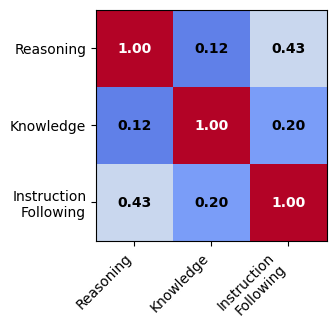

In [13]:
if d>1:
    vmin=0
    vmax=1
    Sigma = np.cov(Z.T)
    
    plt.figure(figsize=(d,d))  # Set the figure size (width, height) in inches
    plt.imshow(Sigma, cmap=colormap, vmin=vmin, vmax=vmax)
    plt.xticks(np.arange(d), labels=factor_labels, rotation=45, ha="right")  # Set the x-tick labels
    plt.yticks(np.arange(d), labels=factor_labels, rotation=0, ha="right")  # Set the y-tick labels
    
    threshold = .8
    for i in range(len(Sigma)):
        for j in range(len(Sigma.T)):
            value = Sigma[i, j]
            color = "black" if value < threshold else "white"  # Conditional color
            text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#
    
    plt.savefig(f'../plots/skills-correlation_{d}.pdf', bbox_inches='tight', dpi=400, transparent=False)
    plt.show()

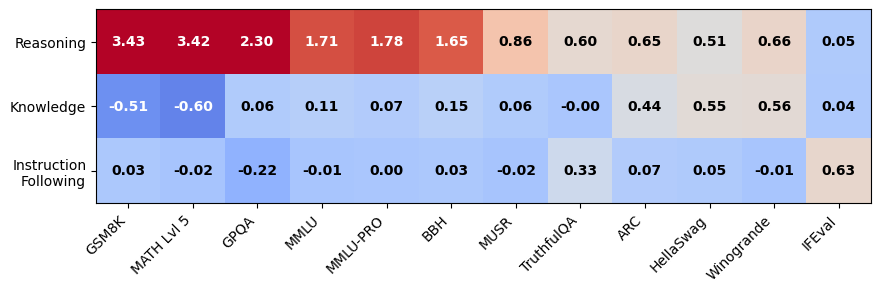

In [14]:
vmin=-1
vmax=2

plt.figure(figsize=(10, 6))  # Set the figure size (width, height) in inches
plt.imshow(L_rot, cmap=colormap, vmin=vmin, vmax=vmax)
plt.xticks(np.arange(len(Y_names)), labels=Y_names, rotation=45, ha="right")  # Set the x-tick labels
plt.yticks(np.arange(d), labels=factor_labels, rotation=0, ha="right")  # Set the y-tick labels

inter = [-.3,1.6]
for i in range(len(L_rot)):
    for j in range(len(L_rot.T)):
        value = L_rot[i, j]
        color = "black" if value > inter[0] and  value < inter[1] else "white"  # Conditional color
        text = plt.text(j, i, f'{value:.2f}', size=10, ha="center", va="center", color=color, weight='bold')#

plt.savefig(f'../plots/loadings_{d}.pdf', bbox_inches='tight', dpi=400, transparent=False)
plt.show()

Instruction-tuning vs skills

In [15]:
families_inst = ['falcon-instruct', 'gemma-it', 'llama-2-chat', 'meta-llama-3-instruct',
 'qwen1.5-chat','recurrentgemma-it', 'yi-1.5-chat']
families = ['falcon', 'gemma', 'llama-2', 'meta-llama-3',
 'qwen1.5','recurrentgemma', 'yi-1.5']

#skills = model2.Z1.numpy()
skills = Z-Z.mean(0)
effects={}
for family,family_inst in zip(families, families_inst):
    sizes =  np.unique(data.loc[(np.array(data['Family']==family_inst))].logS)
    effects[family] = []
    for size in sizes:
        select = np.zeros((data.shape[0],1))
        ind1 = np.argmax(np.array(data['Family']==family_inst) * np.array(data['logS']==size))
        ind2 = np.argmax(np.array(data['Family']==family) * np.array(data['logS']==size))
        
        effects[family].append([skills[ind1].tolist(),skills[ind2].tolist()])
    effects[family] = np.array(effects[family])
#effects

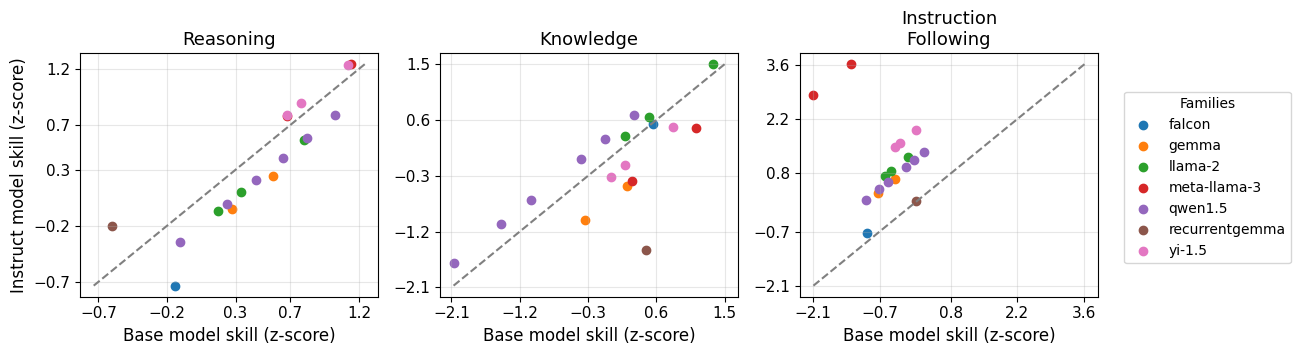

In [16]:
if d>1:
    n_skills = effects[family].shape[-1]  # Number of skills
    fig, axs = plt.subplots(1, n_skills, figsize=(13, 3.65))  # Adjust size as needed , sharex=True, sharey=True
    
    for skill in range(n_skills):
        ax = axs[skill]
        
        # Determine min/max for the current skill across all families
        min_val = np.min([ef[:, :, skill].min() for ef in effects.values()])
        max_val = np.max([ef[:, :, skill].max() for ef in effects.values()])
    
        # Plot data for each family
        for family in effects.keys():
            ax.scatter(effects[family][:, 1, skill], effects[family][:, 0, skill], label=family)
        
        ax.plot([min_val, max_val], [min_val, max_val], color='gray', linestyle='--')  # Diagonal line
        
        ax.set_title(factor_labels[skill], size=13)
        ax.set_xlabel('Base model skill (z-score)', size=12)
        if skill == 0:  # Only set y-label on the first subplot
            ax.set_ylabel('Instruct model skill (z-score)', size=12)
    
        # Create a common set of ticks for both axes
        ticks = np.linspace(min_val, max_val, num=5)  # Adjust `num` for more or fewer ticks
        ticks = np.round(ticks, 1)
        
        # Set the same ticks for both x and y axes
        ax.set_xticks(ticks)
        ax.set_yticks(ticks)
        
        ax.tick_params(axis='both', which='major', labelsize=11)  # Change major tick size
        #ax.tick_params(axis='both', which='minor', labelsize=10)  # Change minor tick size
        ax.grid(alpha=.3)
        
    # Add a shared legend on the right
    handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels, loc='center right', title="Families")
    
    plt.tight_layout(rect=[0, 0, .86, 1])  # Adjust the layout to make room for the legend
    plt.savefig(f'../plots/it_{d}.pdf', bbox_inches='tight', dpi=400, transparent=False)
    plt.show()

Level curves

In [17]:
def f(x, y, w):
    return x*w[0] + y*w[1] + x*y*w[2]

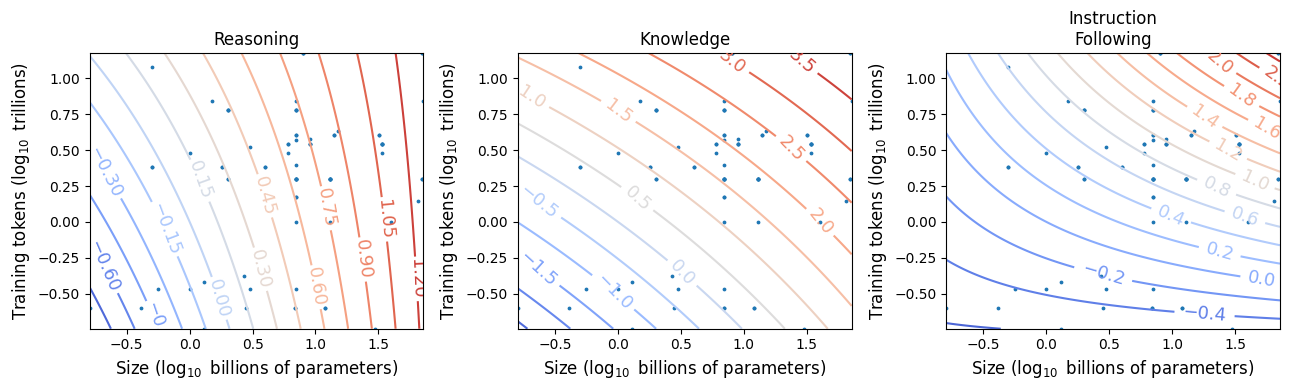

In [18]:
if d>1:
    W = B_rot[:3]
    n_skills = W.shape[-1]
    
    # Create a figure and an array of subplots
    fig, axs = plt.subplots(1, n_skills, figsize=(13, 4))  # Adjust figsize for side-by-side display
    
    for skill in range(n_skills):
        w = W[:,skill]
        
        # Create a grid of x and y values
        bins = 200
        perc_min = np.percentile(X, 0, axis=0)
        perc_max = np.percentile(X, 100, axis=0)
        s = np.linspace(perc_min[0], perc_max[0], bins)
        t = np.linspace(perc_min[1], perc_max[1], bins)
        S, T = np.meshgrid(s, t)
        
        # Compute the function values over the grid
        ZZ = f(S, T, w)
        
        # Plot the level curves (contour plot)
        contour = axs[skill].contour(S, T, ZZ, levels=15, cmap=colormap)
        axs[skill].clabel(contour, inline=True, fontsize=13)
        axs[skill].scatter(X[:,0], X[:,1], s=3)
        axs[skill].set_title(factor_labels[skill])
        axs[skill].set_xlabel('Size ($\\log_{10}$ billions of parameters)', size=12)
        axs[skill].set_ylabel('Training tokens ($\\log_{10}$ trillions)', size=12)
        #axs[skill].set_xscale('log')
        #axs[skill].set_yscale('log')
        ax.tick_params(axis='both', which='major', labelsize=11)  # Change major tick size
        #axs[skill].grid(alpha=0.3)
    
    # Adjust the layout to prevent overlap
    plt.tight_layout()
    
    plt.savefig(f'../plots/level-curves_{d}.pdf', bbox_inches='tight', dpi=400, transparent=False)
    plt.show()
